<a href="https://colab.research.google.com/github/tiyasadey3/GEN_AI/blob/main/Image_Caption_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install --quiet torch torchvision transformers pillow crewai

In [ ]:
!pip install -q langchain langchain_community langchain-openai

In [ ]:
!pip install colab-xterm

In [4]:
%load_ext colabxterm

In [ ]:
%xterm

In [6]:
from crewai import Agent, Task, Crew
from crewai.process import Process
from langchain.llms import Ollama
from google.colab import files
from IPython.display import display
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

Saving picture.jpeg to picture.jpeg


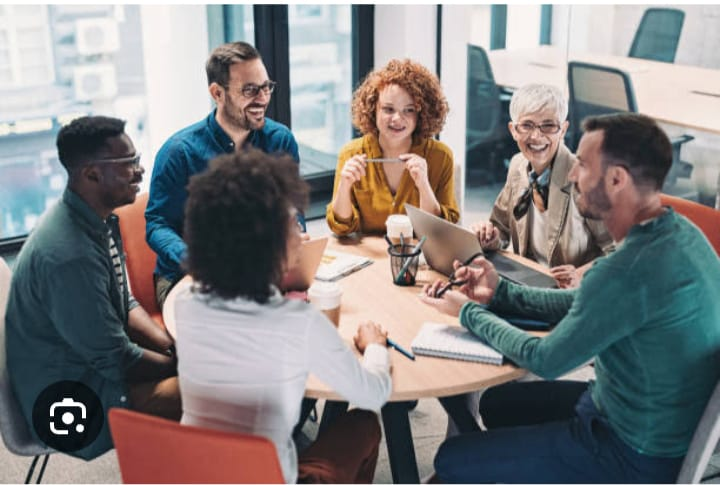

In [7]:
# Step 1: Upload and show the image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
img = Image.open(image_path).convert('RGB')
display(img)

In [ ]:
# Step 2: Use BLIP for real image understanding
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
inputs = processor(img, return_tensors="pt")
with torch.no_grad():
    out = model.generate(**inputs)
    blip_description = processor.decode(out[0], skip_special_tokens=True)

In [9]:
print("BLIP Image Description:", blip_description)

BLIP Image Description: a group of people sitting around a table with a laptop


In [ ]:
# Step 3: LLaMA 3 for caption, alt-text, etc.
llm = Ollama(model='ollama/llama3')

In [11]:
# Agents
image_analyst = Agent(
    role="Image Analyst",
    goal="Expand the base description into a detailed analysis of color, mood, and composition",
    backstory="You are a visual analyst who interprets emotion and atmosphere in visual art.",
    llm=llm,
    allow_delegation=False,
    verbose=False
)

alt_text_writer = Agent(
    role="Alt-Text Writer",
    goal="Create clear, concise alt-text for accessibility tools",
    backstory="You're an accessibility specialist, excellent at writing compact, descriptive alt-text.",
    llm=llm,
    allow_delegation=False,
    verbose=False
)

caption_creator = Agent(
    role="Social Media Caption Wizard",
    goal="Write a fun, catchy caption for Instagram or Twitter based on the image description",
    backstory="You're a social media expert with a great sense of humor and trends.",
    llm=llm,
    allow_delegation=False,
    verbose=False
)

In [12]:
# Tasks (now based on BLIP's actual result)
analysis_task = Task(
    description=f"Based on this BLIP-generated summary of an image: '{blip_description}', analyze its visual tone, color, and mood.",
    agent=image_analyst,
    expected_output="Detailed aesthetic and emotional analysis of the image."
)

alt_text_task = Task(
    description=f"Write a short alt-text for screen readers based on the image: '{blip_description}'",
    agent=alt_text_writer,
    expected_output="Concise alt-text for the image."
)

caption_task = Task(
    description=f"Create an engaging caption for the image. Here's a description: '{blip_description}'",
    agent=caption_creator,
    expected_output="A creative social media caption."
)


In [13]:
# Crew
image_crew = Crew(
    agents=[image_analyst, alt_text_writer, caption_creator],
    tasks=[analysis_task, alt_text_task, caption_task],
    verbose=0,
    process=Process.sequential
)

In [14]:
# Run
result = image_crew.kickoff()
print(result)

"Collaborative vibes only! When a group of awesome people come together to get things done Who else is loving the energy and productivity that comes with working together? Share your own collaborative moments with us and let's keep the good vibes going! #collaboration #productivity #teamwork"
